In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import cycler

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

### Obtencion de Datos

In [3]:
def preprocessing_rava(symbol):

    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.common.by import By
    from bs4 import BeautifulSoup
    from io import StringIO
    import pandas as pd
    import time
    
    # Configuración del navegador sin ventana (headless)
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)

    # Acumulador de dataframes
    dataframes = []

    for ticker in symbol:
        print(f"Obteniendo datos de {ticker}...")
        url = f"https://www.rava.com/perfil/{ticker}"
        driver.get(url)
        time.sleep(5)  # esperar carga inicial

        # Hacer clic en "Ver más" 2 veces
        for _ in range(2):  # ajustar según cuánto histórico querés
            try:
                boton = driver.find_element(By.CSS_SELECTOR, "p.ver")
                driver.execute_script("arguments[0].click();", boton)
                time.sleep(2)  # esperar que cargue nuevos datos
            except:
                print(f"No hay más datos para cargar en {ticker}.")
                break

        # Extraer tabla completa cargada
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        try:
            tabla_html = soup.find("div", id="scroll").find("table")
            df = pd.read_html(StringIO(str(tabla_html)))[0]

            # Procesar columnas
            df['fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True).dt.date
            df.set_index('fecha', inplace=True)
            df = df[['Cierre']].rename(columns={'Cierre': 'Adj Close'})

            dataframes.append(df)
        except Exception as e:
            print(f"No se pudo obtener {ticker}: {e}")

    # Cerrar el navegador
    driver.quit()

    df_final = pd.concat(dataframes, axis=1) # Unir todas las series por fecha
    df_final = df_final.sort_index()

    
    # Convertir de string a número flotante
    df_final['Adj Close'] = (
        df['Adj Close']
        .astype(str)
        .str.replace('.', '', regex=False)   # quita separador de miles
        .str.replace(',', '.', regex=False)  # cambia coma por punto decimal
        .astype(float)
    )
#     print(df_final.head())
    return (df_final)

    # Guardar como CSV
    # df_final.to_csv("cotizaciones_rava.csv")

In [4]:
df = preprocessing_rava(['GGAL'])

C:\Users\asus\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Obteniendo datos de GGAL...


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

def check_gbm_assumptions(price_series: pd.Series, plot=True, alpha=0.05):
    """
    Verifica de forma práctica los supuestos básicos para usar un GBM en precios:
      1) Precios positivos.
      2) Log-retornos aproximadamente normales.
      3) Log-retornos sin autocorrelación significativa.
      4) Log-retornos^2 sin autocorrelación fuerte (pocos efectos ARCH).
      5) Media y varianza de log-retornos relativamente estables en el tiempo.

    Parameters
    ----------
    price_series : pd.Series
        Serie de precios (índice temporal, valores > 0).
    plot : bool
        Si True, muestra gráficos (histograma, QQ-plot, ACF, etc.).
    alpha : float
        Nivel de significancia para los tests (default 0.05).

    Returns
    -------
    results : dict
        Diccionario con p-values y conclusiones de cada test.
    """

    results = {}

    # ------------------------------------------------------------------
    # 0. Limpieza básica
    # ------------------------------------------------------------------
    price = price_series.dropna()

    # 1) Precios positivos
    all_positive = (price > 0).all()
    results["precios_positivos"] = all_positive

    # Log-retornos
    log_ret = np.log(price).diff().dropna()

    # ------------------------------------------------------------------
    # 1. Normalidad de los log-retornos
    # ------------------------------------------------------------------
    # Jarque-Bera (colas + asimetría)
    jb_stat, jb_p = stats.jarque_bera(log_ret)
    results["normalidad_JB_pvalue"] = float(jb_p)

    # KS sobre log-retornos estandarizados
    z = (log_ret - log_ret.mean()) / log_ret.std(ddof=1)
    ks_stat, ks_p = stats.kstest(z, "norm")
    results["normalidad_KS_pvalue"] = float(ks_p)

    # ------------------------------------------------------------------
    # 2. Autocorrelación en log-retornos (i.i.d. en media)
    # ------------------------------------------------------------------
    ljung_ret = acorr_ljungbox(log_ret, lags=[5, 10, 20], return_df=True)
    results["ljungbox_retornos"] = ljung_ret.to_dict("index")  # dict por lag

    # ------------------------------------------------------------------
    # 3. Autocorrelación en log-retornos^2 (volatilidad constante)
    # ------------------------------------------------------------------
    ljung_ret2 = acorr_ljungbox(log_ret**2, lags=[5, 10, 20], return_df=True)
    results["ljungbox_retornos_cuadrado"] = ljung_ret2.to_dict("index")

    # Test ARCH (Engle) para heterocedasticidad
    arch_stat, arch_p, _, _ = het_arch(log_ret)
    results["ARCH_pvalue"] = float(arch_p)

    # ------------------------------------------------------------------
    # 4. Estabilidad de media y varianza en el tiempo
    # ------------------------------------------------------------------
    # Divido la muestra en dos mitades
    half = len(log_ret) // 2
    first_half = log_ret.iloc[:half]
    second_half = log_ret.iloc[half:]

    # Test de igualdad de medias (t-test)
    t_stat, t_p = stats.ttest_ind(first_half, second_half, equal_var=False)
    results["t_test_medias_pvalue"] = float(t_p)

    # Test de igualdad de varianzas (Levene)
    lev_stat, lev_p = stats.levene(first_half, second_half)
    results["levene_varianzas_pvalue"] = float(lev_p)

    # ------------------------------------------------------------------
    # 5. Conclusiones simplificadas
    # ------------------------------------------------------------------
    conclusiones = {}

    conclusiones["precios_positivos"] = all_positive

    conclusiones["logret_aprox_normal"] = (
        jb_p > alpha and ks_p > alpha
    )  # no rechazo normalidad a nivel alpha

    conclusiones["sin_autocorrel_en_retornos"] = bool(
        (ljung_ret["lb_pvalue"] > alpha).all()
    )

    conclusiones["sin_autocorrel_en_retornos2"] = bool(
        (ljung_ret2["lb_pvalue"] > alpha).all()
    )

    conclusiones["sin_efecto_ARCH_fuerte"] = (arch_p > alpha)

    conclusiones["medias_estables"] = (t_p > alpha)
    conclusiones["varianzas_estables"] = (lev_p > alpha)

    results["conclusiones_bool"] = conclusiones

    # ------------------------------------------------------------------
    # 6. Imprimir resumen
    # ------------------------------------------------------------------
    print("\n================= CHECK GBM =================")
    print(f"Observaciones válidas: {len(log_ret)}")
    print("--------------------------------------------")
    print(f"Precios positivos: {all_positive}")
    print(f"Normalidad (Jarque-Bera) p-value  : {jb_p:.4f}")
    print(f"Normalidad (KS sobre z) p-value   : {ks_p:.4f}")
    print("Ljung-Box retornos (p-values):")
    print(ljung_ret["lb_pvalue"])
    print("Ljung-Box retornos^2 (p-values):")
    print(ljung_ret2["lb_pvalue"])
    print(f"Test ARCH p-value                 : {arch_p:.4f}")
    print(f"T-test medias 1ª vs 2ª mitad p   : {t_p:.4f}")
    print(f"Levene varianzas 1ª vs 2ª mitad p: {lev_p:.4f}")
    print("--------------------------------------------")
    print("Conclusiones (True = no se rechaza el supuesto):")
    for k, v in conclusiones.items():
        print(f"  {k}: {v}")
    print("============================================\n")

    # ------------------------------------------------------------------
    # 7. Gráficos opcionales
    # ------------------------------------------------------------------
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # Histograma + densidad Normal teórica
        ax = axes[0, 0]
        ax.hist(log_ret, bins=40, density=True, alpha=0.6, label="Log-retornos")
        x = np.linspace(log_ret.min(), log_ret.max(), 200)
        pdf = stats.norm.pdf(x, loc=log_ret.mean(), scale=log_ret.std(ddof=1))
        ax.plot(x, pdf, "r--", label="Normal ajustada")
        ax.set_title("Histograma log-retornos")
        ax.legend()

        # QQ-plot
        ax = axes[0, 1]
        qqplot(log_ret, line="s", ax=ax)
        ax.set_title("QQ-plot vs Normal")

        # ACF retornos
        ax = axes[1, 0]
        plot_acf(log_ret, lags=20, ax=ax)
        ax.set_title("ACF log-retornos")

        # ACF retornos^2
        ax = axes[1, 1]
        plot_acf(log_ret**2, lags=20, ax=ax)
        ax.set_title("ACF log-retornos^2")

        plt.tight_layout()
        plt.show()

    return results



================= CHECK GBM =================
Observaciones válidas: 226
--------------------------------------------
Precios positivos: True
Normalidad (Jarque-Bera) p-value  : 0.0000
Normalidad (KS sobre z) p-value   : 0.0203
Ljung-Box retornos (p-values):
5     0.220383
10    0.144101
20    0.204827
Name: lb_pvalue, dtype: float64
Ljung-Box retornos^2 (p-values):
5     0.489771
10    0.771119
20    0.964037
Name: lb_pvalue, dtype: float64
Test ARCH p-value                 : 0.8112
T-test medias 1ª vs 2ª mitad p   : 0.8237
Levene varianzas 1ª vs 2ª mitad p: 0.8865
--------------------------------------------
Conclusiones (True = no se rechaza el supuesto):
  precios_positivos: True
  logret_aprox_normal: False
  sin_autocorrel_en_retornos: True
  sin_autocorrel_en_retornos2: True
  sin_efecto_ARCH_fuerte: True
  medias_estables: True
  varianzas_estables: True



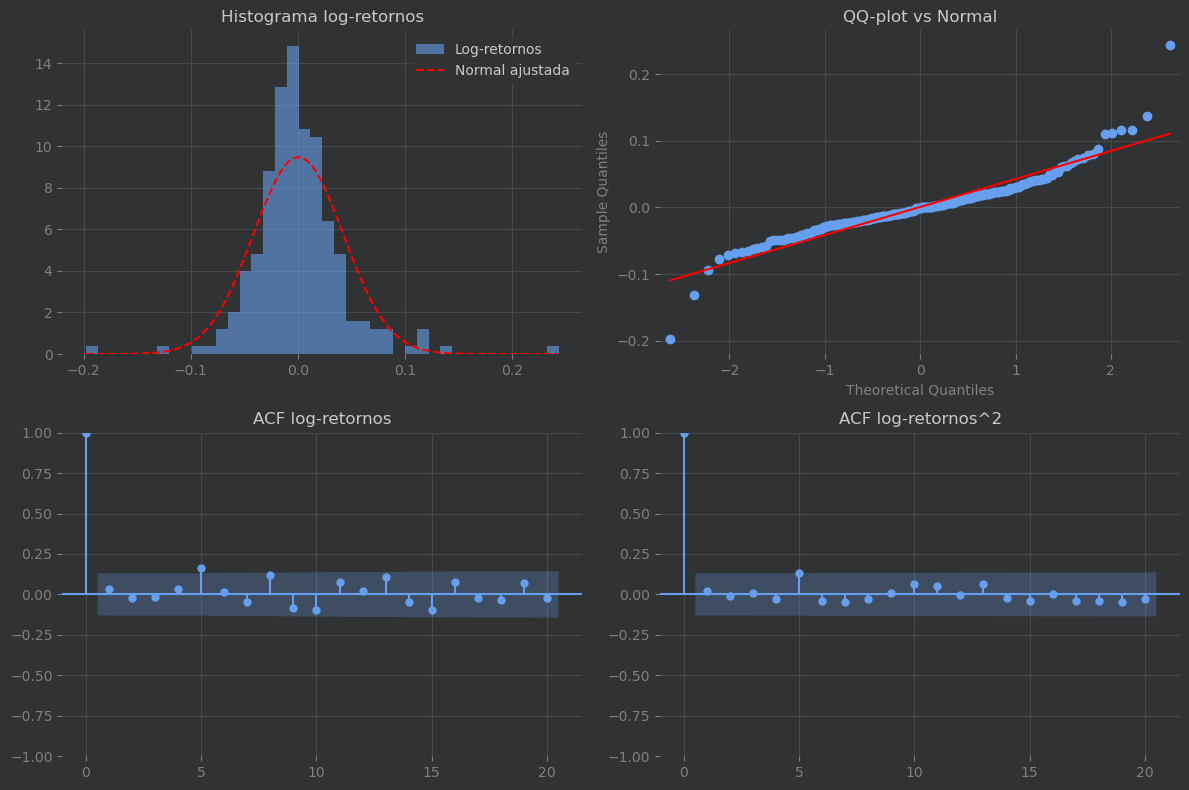

In [7]:
price_series = df["Adj Close"]
res_gbm = check_gbm_assumptions(price_series, plot=True, alpha=0.05)


* Los precios son siempre positivos y los log-retornos no presentan autocorrelación significativa ni en nivel ni en el cuadrado, y la media y la varianza se mantienen estables entre la primera y la segunda mitad del período.

* Sin embargo, los tests de Jarque–Bera y Kolmogorov–Smirnov rechazan la normalidad de los log-retornos: la distribución presenta desviaciones respecto a una Normal (colas más pesadas y/o asimetría).

En resumen, los datos cumplen razonablemente con la independencia y la estabilidad de parámetros que supone un Movimiento Browniano Geométrico (GBM), pero no con el supuesto de normalidad exacta de los retornos.
Por lo tanto, usar GBM como modelo para Monte Carlo es una aproximación de primer orden aceptable, aunque es importante aclarar que infravalora el peso de los eventos extremos. Para capturar mejor estas colas pesadas podrían considerarse extensiones (por ejemplo, retornos t-Student, modelos GARCH con distribución no normal, etc.).

### Calculo de Rentabilidad y Volatilidad Historica

In [8]:
# Calcular retornos logarítmicos diarios
log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# Estimar rendimiento promedio anualizado (mu)
mu = log_returns.mean() * 252  # 252 días hábiles al año

# Estimar volatilidad anualizada (sigma)
sigma = log_returns.std() * np.sqrt(252)

print(f"μ (esperado anual): {mu:.4f}")
print(f"σ (volatilidad anual): {sigma:.4f}")


μ (esperado anual): 0.1373
σ (volatilidad anual): 0.6687


Falta con volatilidad implicita, la cual proviene del metodo numerico de despejar de la volatilidad del movimiento geometrico browniano

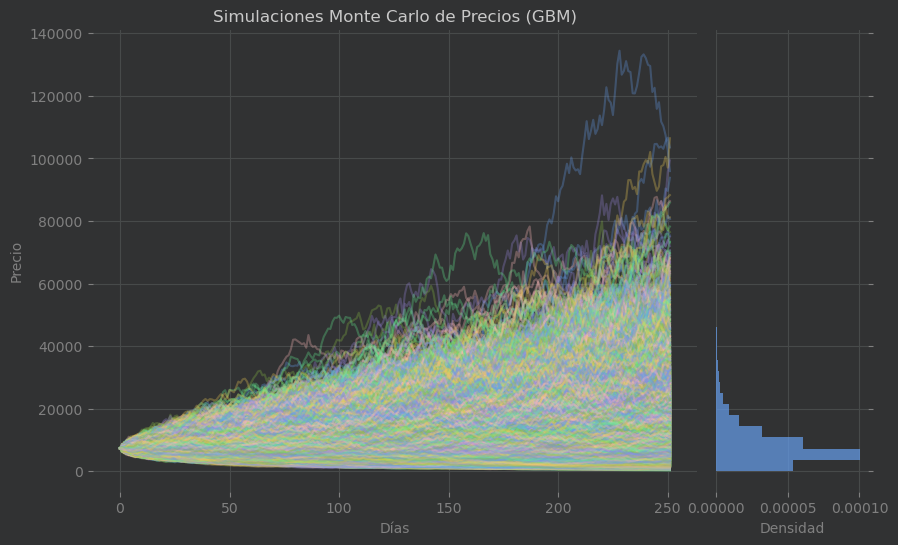

In [13]:
# === PARÁMETROS INICIALES ===
S0 = df["Adj Close"].iloc[-1]     # Precio actual
mu = mu                           # Rendimiento promedio anual
sigma = sigma                     # Volatilidad anual
T = 1                             # Horizonte de tiempo en años
n_simulaciones = 100000             # Número de simulaciones
n_pasos = 252                     # Días hábiles por año
semilla = 42                      # ← Semilla fija para reproducibilidad (puede ser None)

# === CONFIGURAR SEMILLA ===
if semilla is not None:
    np.random.seed(semilla)

# === SIMULACIÓN GBM ===
dt = T / n_pasos
precios = np.zeros((n_pasos, n_simulaciones))
precios[0] = S0

for t in range(1, n_pasos):
    Z = np.random.standard_normal(n_simulaciones)  # Aleatorio normal
    precios[t] = precios[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Tomamos los precios finales de cada trayectoria (última fila)
precios_finales = precios[-1, :]

# --- FIGURA CON DOS SUBPLOTS: IZQ = CAMINOS, DER = DISTRIBUCIÓN ---
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Eje principal: trayectorias en el tiempo
ax_paths = fig.add_subplot(gs[0, 0])
ax_paths.plot(precios, alpha=0.3)  # muchas líneas -> alpha bajo
ax_paths.set_title("Simulaciones Monte Carlo de Precios (GBM)")
ax_paths.set_xlabel("Días")
ax_paths.set_ylabel("Precio")
ax_paths.grid(True)

# Eje secundario: histograma vertical de precios finales
ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_paths)

ax_hist.hist(
    precios_finales,
    bins=30,
    orientation="horizontal",
    density=True,
    alpha=0.7
)

ax_hist.set_xlabel("Densidad")
ax_hist.yaxis.tick_right()                   # ticks de precio a la derecha
ax_hist.yaxis.set_label_position("right")    # (opcional)
ax_hist.grid(True, axis="x")
plt.setp(ax_hist.get_yticklabels(), visible=False)  # ocultar etiquetas duplicadas

plt.show()


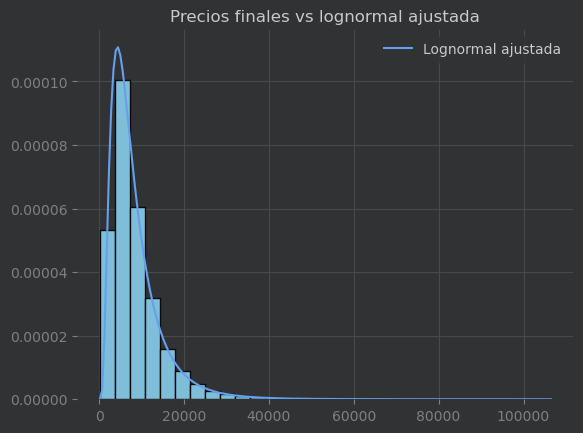

In [14]:
# Ajustar una lognormal a los datos
shape, loc, scale = stats.lognorm.fit(precios_finales, floc=0)

x = np.linspace(precios_finales.min(), precios_finales.max(), 200)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

# plt.hist(precios_finales, bins=30, density=True, alpha=0.6, label="Simulado")
plt.hist(precios_finales, bins=30, color='skyblue', alpha=0.9,edgecolor='black',density=True)
plt.plot(x, pdf_lognorm, label="Lognormal ajustada")
plt.title("Precios finales vs lognormal ajustada")
plt.legend()
plt.show()

In [11]:
# precios_finales

### Estadísticas descriptivas de precios finales

In [15]:
media = np.mean(precios_finales)
mediana = np.median(precios_finales)
desv_std = np.std(precios_finales)
p5 = np.percentile(precios_finales, 5)
p95 = np.percentile(precios_finales, 95)

print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Desviación estándar: {desv_std:.2f}")
print(f"Percentil 5%: {p5:.2f}")
print(f"Percentil 95%: {p95:.2f}")
# precios_finales.describe()

Media: 8413.76
Mediana: 6737.98
Desviación estándar: 6262.12
Percentil 5%: 2258.62
Percentil 95%: 20129.56


### Intervalo de confianza y probabilidad de superar cierto umbral

In [16]:
prob_alza = np.mean(precios_finales > S0)
print(f"Probabilidad de que el precio suba (S_T > {S0}): {prob_alza:.2%}")


Probabilidad de que el precio suba (S_T > 7350.0): 44.81%


### Graficar percentiles de trayectoria

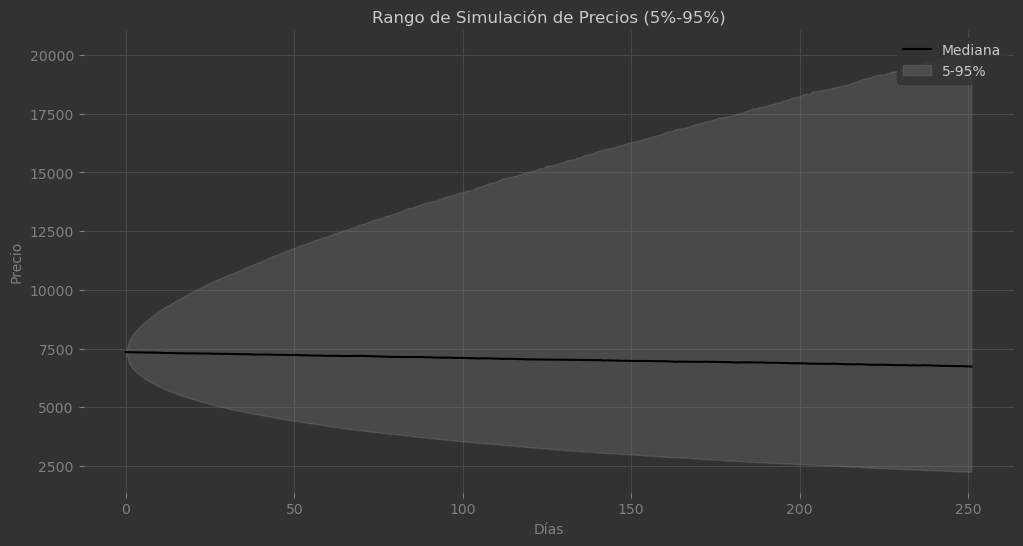

In [18]:
import seaborn as sns

p5 = np.percentile(precios, 5, axis=1)
p50 = np.percentile(precios, 50, axis=1)
p95 = np.percentile(precios, 95, axis=1)

plt.figure(figsize=(12,6))
plt.plot(p50, label='Mediana', color='black')
plt.fill_between(range(n_pasos), p5, p95, color='gray', alpha=0.3, label='5-95%')
plt.title('Rango de Simulación de Precios (5%-95%)')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()
